In [209]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import sigmf
from data_path import data_path

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [210]:
# handle = sigmf.sigmffile.fromfile(data_path + '/763MHz_15360KSPS.sigmf-data')
# delta_f = 450e3
# f = 763e6
# mu = 0
# samp_rate_error = 1
# apply_fine_CFO = 1

handle = sigmf.sigmffile.fromfile(data_path + '/3627MHz_30720KSPS.sigmf-data')
delta_f = -600e3
f = 3672e6
mu = 1
samp_rate_error = 1 - 1e3/3672e6
apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
# delta_f = 0
# f = 1
# mu = 0
# samp_rate_error = 1
# apply_fine_CFO = 0  # why does fine_CFO fail for perfect input file??

x_orig = handle.read_samples()
x_orig /= max(x_orig.real.max(), x_orig.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)



In [223]:
# The units here are samples
SCS = 15e3 * 2**mu
Tu = int(fs/SCS) # useful time of a symbol
cp1 = int(160 * 2**(-mu))
cp2 = int(144 * 2**(-mu))

In [212]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
# verified with nrPSS() in Matlab
def calc_PSS(N_id_2):
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([0, 1, 1, 0, 1, 1, 1])
    for i in np.arange(0, 127 - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2
    d_PSS = np.zeros(n, 'int32')
    for n in np.arange(0, 127):
        m = (n + 43*N_id_2) % 127  # offset based on N_id_2
        d_PSS[n] = 1 - 2*x[m]  # BPSK modulation
    return d_PSS

In [213]:
PSS = [calc_PSS(0), calc_PSS(1), calc_PSS(2)]
subcarriers_ss = slice(Tu//2 - 1 - 63, Tu//2 - 1 + 64)
PSS_time = np.empty((3, Tu), 'complex')
for j in range(PSS_time.shape[0]):
    PSS_all = np.zeros(Tu, 'complex')
    PSS_all[subcarriers_ss] = PSS[j]
    PSS_time[j] = np.fft.ifft(np.fft.fftshift(PSS_all))
    PSS_time[j] *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(PSS_time.shape[1])))  


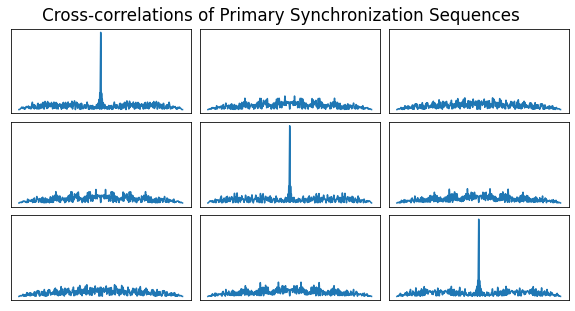

In [214]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(PSS_time[j], PSS_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('Cross-correlations of Primary Synchronization Sequences', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

In [215]:
PSS_corr = np.empty((3, int(25e-3 * fs)), 'complex') # do cross correlation for 25 ms, bcs SSB comes every 20 ms
for j in range(PSS_corr.shape[1]):
    PSS_corr[:, j] = np.sum(x_orig[j:][:Tu] * np.conjugate(PSS_time), axis=1)
t_corr = np.arange(PSS_corr.shape[1])/fs

Text(0.5, 0.93, 'Cross-correlation of signal with Primary Synchronization Sequences')

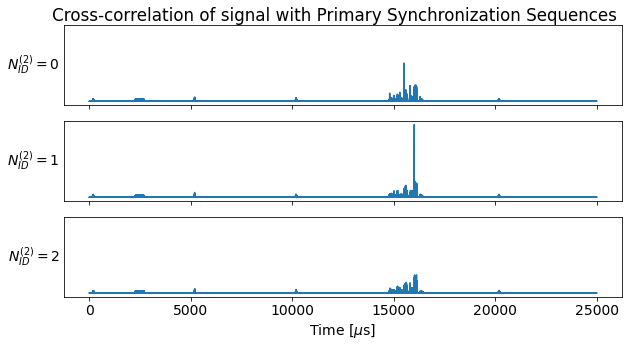

In [216]:
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for j, ax in enumerate(axs.ravel(order='F')):
    ax.plot(t_corr*1e6, np.abs(PSS_corr[j]))
    ax.set_yticks([])
    ax.set_ylabel(f'$N_{{ID}}^{{(2)}} = {j}$', rotation=0,
        horizontalalignment='right', verticalalignment='center')
axs[-1].set_xlabel('Time [$\mu$s]')
plt.suptitle('Cross-correlation of signal with Primary Synchronization Sequences', y=0.93)

In [217]:
idx, a0 = np.unravel_index(np.argmax(np.abs(PSS_corr)), PSS_corr.shape)
N_id_2 = idx % 3
N_id_2, idx, a0

(1, 1, 492020)

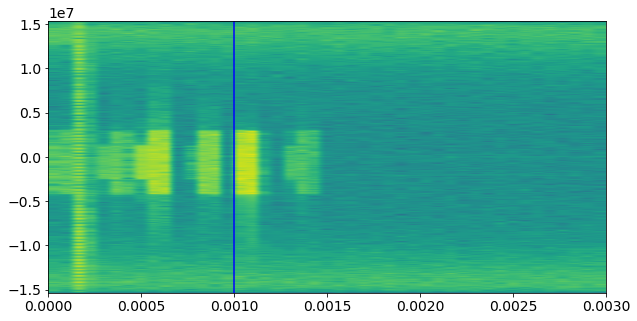

In [218]:
nFFT = 2048
x0 = max(0, a0 - 1E-3*fs) # display 1 ms before detected PSS
plt.specgram(x_orig[int(x0):int(x0)+nFFT*45], Fs=fs, NFFT=nFFT, noverlap=0)
#plt.specgram(x_orig, Fs=fs, NFFT=nFFT, noverlap=0)
a0_time = (a0-x0)/fs
plt.axvline(x = a0_time, color = 'b', label = 'axvline - full height')

In [219]:
# fine CFO
# tuns out this is accurate to about +-4 Hz
# 3627MHz_30720KSPS.sigmf-data needs -2.5 Hz additional correction to be perfect
C0 =  np.sum(x_orig[a0:a0+Tu//2] * np.conjugate(PSS_time[N_id_2][:Tu//2]))
C1 = np.sum(x_orig[a0+Tu//2:a0+Tu] * np.conjugate(PSS_time[N_id_2][-Tu//2:]))
delta_phi = -np.arctan(np.imag(C1*np.conjugate(C0))/np.real(C1*np.conjugate(C0)))*fs/(np.pi*Tu)
print(f"PSS based fine CFO {delta_phi:.03f} Hz")
if apply_fine_CFO:
    x = x_orig * np.exp(1j*(2*np.pi*(-delta_phi-delta_f)/fs*np.arange(len(x_orig))))
else:
    x = x_orig * np.exp(1j*(2*np.pi*(-delta_f)/fs*np.arange(len(x_orig))))


PSS based fine CFO -748.658 Hz


In [220]:
n_SSBs = x[a0:].size // int(fs * 20e-3)
syms_pss = np.empty((n_SSBs, 126), 'complex')
#syms_pss_wipe = np.empty_like(syms_pss)
no_dc = np.concatenate((np.arange(63), np.arange(64, 127)))
for j in range(n_SSBs):
    syms = np.fft.fftshift(np.fft.fft(x[a0 + round(20e-3 * fs * j * samp_rate_error):][:Tu]))
    syms_pss[j] = syms[subcarriers_ss][no_dc]
    syms_pss[j] /= max(syms_pss[j].real.max(), syms_pss[j].imag.max())
    #syms_pss_wipe[j] = syms_pss[j] * np.conjugate(PSS[N_id_2][no_dc])
#normalization_factor = max(syms_pss.ravel().real.max(), syms_pss.ravel().imag.max()) # scale all half frames to a common factor, so that differences in amplitude are still visible
#syms_pss /= normalization_factor
#syms_pss_wipe /= normalization_factor

Text(0.5, 0.91, 'PSS symbols (without equalization)')

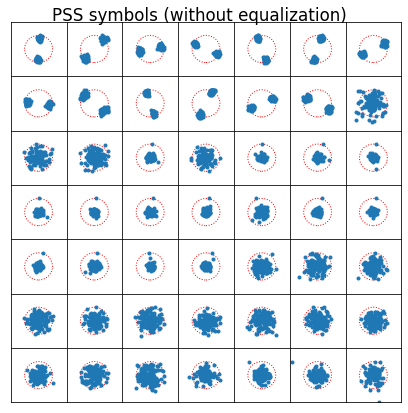

In [221]:
n = int(min(int(np.sqrt(n_SSBs)),10))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols (without equalization)', y=0.91)

In [224]:
syms_sss = np.empty((n_SSBs, 126), 'complex')
a_SSS = a0 + (Tu + (cp2+Tu) + cp2)
no_dc = np.concatenate((np.arange(63), np.arange(64, 127)))
for j in range(n_SSBs):
    syms = np.fft.fftshift(np.fft.fft(x[a_SSS + round(20e-3 * fs * j * samp_rate_error):][:Tu]))
    syms_sss[j] = syms[subcarriers_ss][no_dc]
    syms_sss[j] /= max(syms_sss[j].real.max(), syms_sss[j].imag.max())

Text(0.5, 0.91, 'SSS symbols (without equalization)')

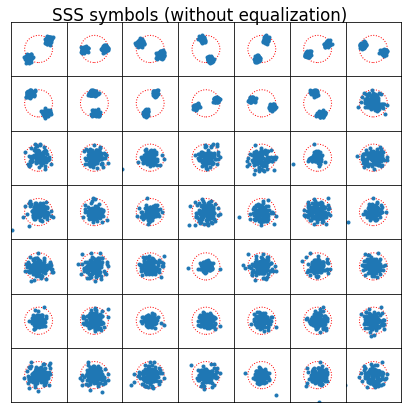

In [225]:
n = int(min(int(np.sqrt(n_SSBs)),10))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols (without equalization)', y=0.91)

In [226]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
def calc_m_seq_0():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence    
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2    
    return x

def calc_m_seq_1():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 1] + x[i]) % 2        
    return x

def gold(N_id_1, N_id_2):
    n = 127
    x_0 = calc_m_seq_0()
    x_1 = calc_m_seq_1()
    d_SSS = np.zeros(n, 'int32')    
    m_0 = 15*int((N_id_1/112)) + 5*N_id_2
    m_1 = N_id_1 % 112
    for n in np.arange(0, 127):
        d_SSS[n] = (1 - 2*x_0[(n + m_0) % 127]) * (1 - 2*x_1[(n + m_1) % 127])
    return d_SSS

SSS = np.zeros((336, 127))
for i in range(336):
    SSS[i, :] = gold(i, N_id_2)

In [227]:
#SSS_corr = np.sum(x_orig[a0 + round(5e-3 * fs * j * samp_rate_error):][:Tu] * np.conjugate(SSS), axis=1)
#t_corr = np.arange(SSS_corr.shape[1])/fs
SSS_corr = np.empty(336, 'complex')
for i in range(SSS_corr.shape[0]):
    SSS_corr[i] = np.sum(syms_sss[0] * np.conjugate(SSS[i][no_dc]), axis=0)
N_id_1 = np.argmax(np.abs(SSS_corr))
N_id = 3*N_id_1 + N_id_2
print(f'N_id = {N_id} (N_id_1 = {N_id_1}, N_id_2 = {N_id_2})')

N_id = 967 (N_id_1 = 322, N_id_2 = 1)
